In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import re

from scipy.stats import f, chi2
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from statsmodels.multivariate.manova import MANOVA

In [2]:
df_train=pd.read_csv("digit-recognizer/train.csv")
df_test=pd.read_csv("digit-recognizer/test.csv")
df_train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df=df_train[(df_train["label"]==0) | (df_train["label"]==1)]

X=df.drop(["label"], axis=1)
y=df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda.fit(X_train, y_train)
# Make predictions on the test data
y_pred = lda.predict(X_test)

# Calculate the accuracy of the model
print("Accuracy on training set: ", lda.score(X_train,y_train))
print("Accuracy on test set: ", lda.score(X_test,y_test))

# Perform MANOVA with Wilks' test
#manova = MANOVA(X_train, y_train)
#m=manova.mv_test()
#m.summary()


cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
class_report= classification_report(y_test, y_pred)

print("\nPrecision:", precision)
print("\nRecall:", recall)
print("\nAccuracy on test set: ", lda.score(X_test,y_test))
print("\nclassification_report: ", class_report)

Accuracy on training set:  0.9951786727169597
Accuracy on test set:  0.9926303854875284
Confusion Matrix:
[[817   4]
 [  9 934]]

Precision: 0.9924198619493332

Recall: 0.9927919421650394

Accuracy on test set:  0.9926303854875284

classification_report:                precision    recall  f1-score   support

           0       0.99      1.00      0.99       821
           1       1.00      0.99      0.99       943

    accuracy                           0.99      1764
   macro avg       0.99      0.99      0.99      1764
weighted avg       0.99      0.99      0.99      1764



### Fisher's Discriminant is given by:
$ F_d(\alpha,\beta)= \frac{(\mu_{d,\alpha}-\mu_{d,\beta})^2}{n_{\alpha}\sigma^2_{d,\alpha}+n_{\beta}\sigma^2_{d,\beta}} $

In [56]:
# Calculate Fisher Discriminant
def calculate_Fisher_Discriminant(df_train, j, k):
    df_filter0=df_train[(df_train["label"]==j)].drop(['label'],axis=1)
    df_filter1=df_train[(df_train["label"]==k)].drop(['label'],axis=1)

    df_filter0_desc=df_filter0.describe()
    df_filter1_desc=df_filter1.describe()
    df_out1=df_filter0_desc.reset_index().merge(
        df_filter1_desc.reset_index(),how="inner", on="index", suffixes=["_0","_1"])
    col_list=list(df_out1.drop(['index'],axis=1).columns)


    df_out=pd.melt(df_out1, id_vars=['index'], value_vars=col_list, var_name='pixel', value_name='values')
    df_out=df_out[(df_out['index']=='count')|(df_out['index']=='mean')|(df_out['index']=='std')]
    df_out['const']=df_out['pixel'].apply(lambda x: re.sub("pixel","",x))
    df_out['const']=df_out['const'].apply(lambda x: re.split("_",x)[0])
    df_out['col']=df_out['index']+"_"+df_out['pixel'].apply(lambda x: re.split("_",x)[1])
    df_out

    df_out2=df_out.pivot(index='const', columns='col', values='values')

    df_out2=df_out.pivot(index='const', columns='col', values='values')
    df_out2["numerator"] = (df_out2['mean_0']-df_out2['mean_1'])**2
    df_out2["denominator"] = (df_out2['count_0']*(df_out2['std_0']**2))+(
        df_out2['count_1']*(df_out2['std_1']**2))
    df_out2["fd"]=np.where(df_out2["denominator"]==0,0,df_out2["numerator"]/df_out2["denominator"])
    #df_out2=df_out2.reset_index()
    #df_out2=df_out2[df_out2['const']!='label']
    min_value = df_out2['fd'].min()
    max_value = df_out2['fd'].max()

    # Min-max normalize the column to a range between 0 and 1
    df_out2['normalized_fd'] = (df_out2['fd'] - min_value) / (max_value - min_value)
    df_out2=df_out2.reset_index()
    
    return df_out2[["const","normalized_fd"]]

In [88]:
def get_image(df):
    fisher_discriminant["const"]=df["const"].apply(lambda x:int(x))
    fisher_discriminant["r"]=fisher_discriminant["const"].apply(lambda x:int(x/28))
    fisher_discriminant["c"]=fisher_discriminant["const"].apply(lambda x:int(x%28))
    i_array = np.empty((28, 28))
    for i in range(28):
        for j in range(28):
            i_array[i,j]=fisher_discriminant[(fisher_discriminant['r']==i) & (fisher_discriminant['c']==j)].reset_index(drop=True).loc[0,'normalized_fd']

    return i_array

Processing: 100%|████████████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.73s/item]


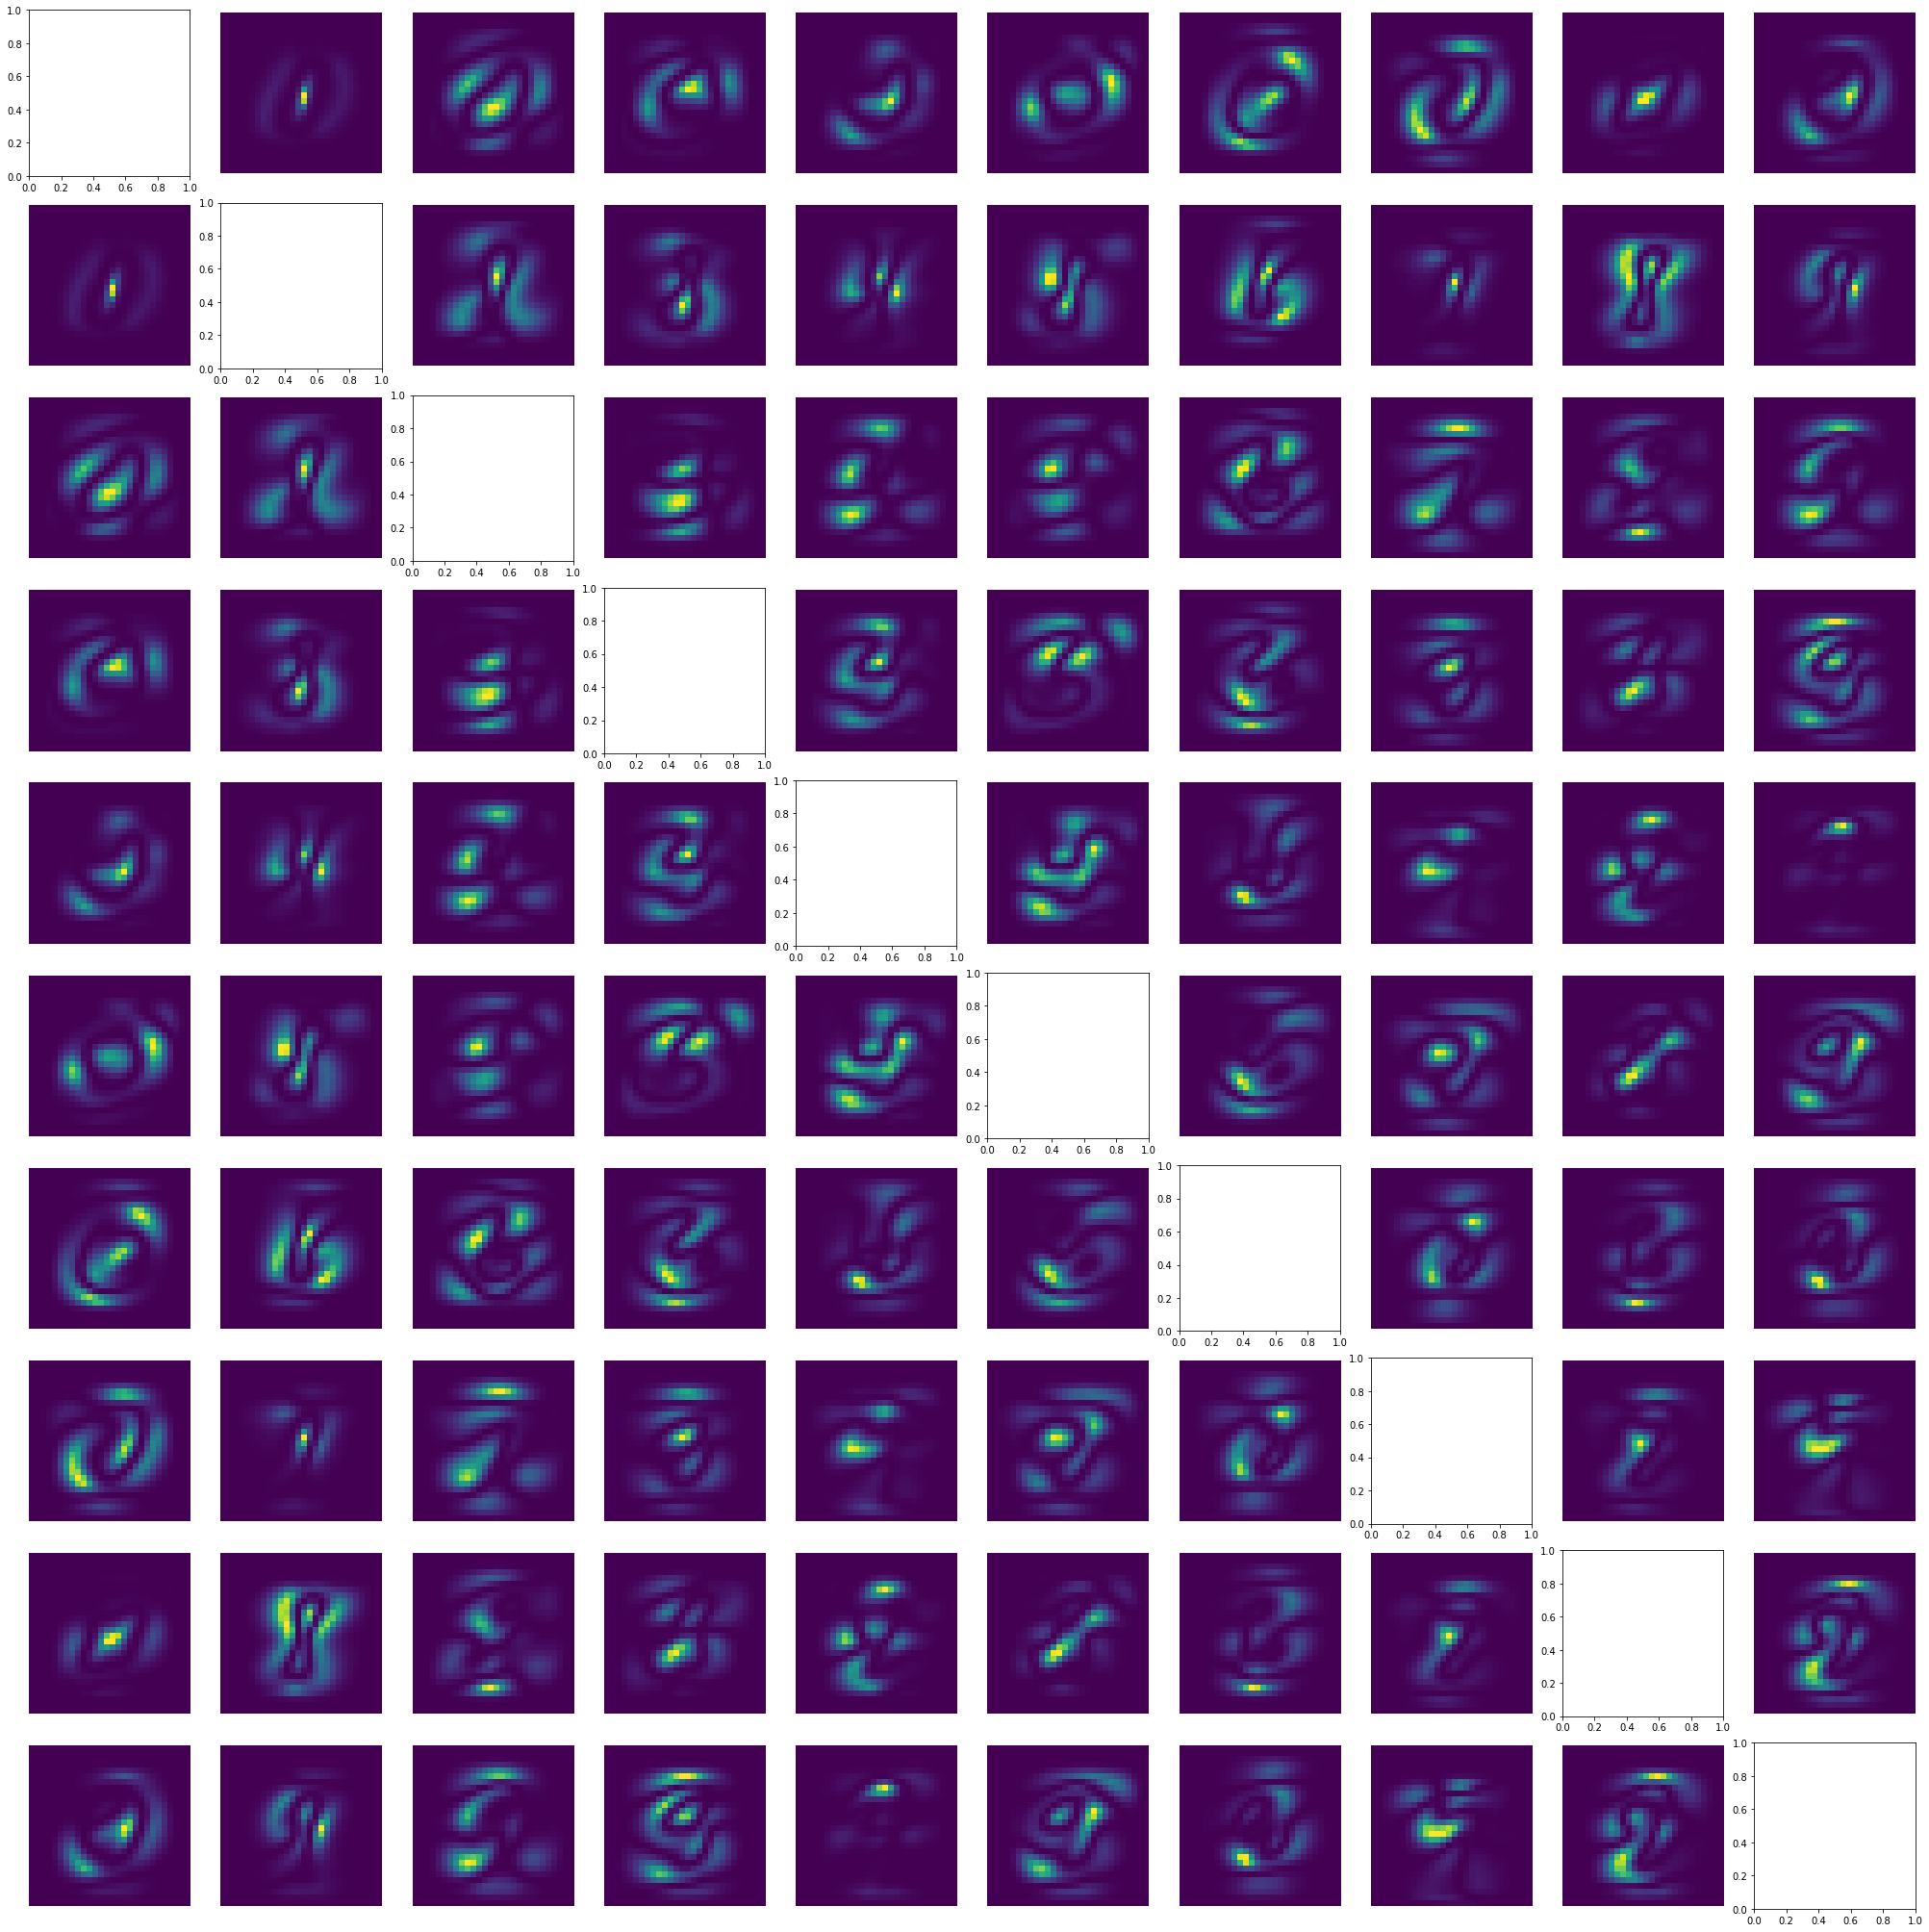

In [109]:
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(28, 28))

for i in  range(10):
    for j in tqdm(range(10), desc="Processing", unit="item"):
        if i==j:
            #axes[i,j].text(0.1,0.1,'NA')
            pass
        else:
            fisher_discriminant=calculate_Fisher_Discriminant(df_train, i, j)
            narr=get_image(fisher_discriminant)
            axes[i, j].imshow(narr)
            axes[i, j].axis('off')

plt.tight_layout()
plt.show()


The Fisher image of each of the pair shows the diffrence between them in the highlighted region.
The region with similar pixel value is not highlighted.